# How the raw data is reinforced using the TabSRALinear?
To illustrate how the raw data is reinforced using the TabSRALinear, we use 2D
toy classification datasets where yellow color is used for the class of interest (Section 3.1 of the paper).
We recall the recall the reinforced vector is:

$$\mathbf o = \mathbf a \odot \mathbf x$$
with $\mathbf a$ the attention vector et $\mathbf x$  the raw input. 

For problem with important number of features, ($p>2$) it makes more sense to visualize the main effects ie $\beta_i  a_i  x_i$ vs $x_i$ first, then the interactions ie $\beta_i  a_i  x_i$ vs $x_j$ for $i \neq j$. One can also use the feature attribution measure as illustrate in the Churn classification example 

## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,train_test_split

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [4]:
sys.path.append('../')
from SRAModels import TabSRALinear
from utils import TrainModel,reset_seed_,Predict, load, save,LinearScaling


## Utils

In [5]:

def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5)
                  )
    return Model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## 2D Interaction 

In [7]:
np.random.seed(42)
x1 = np.random.normal(0,1,3*10000)
x2 = np.random.normal(0,1,3*10000)
X = np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1) ),axis=1)
odd = 5*x1 - 5*x2*(x1>0)
y_c = 1/(1+np.exp(-odd))
y = np.where(y_c>0.5, 1,0)
n_features,n_classes,=2,2
X_train_,X_test_,Y_train_,Y_test_ = train_test_split(X,y,stratify =y ,test_size=0.25,random_state=42)
len(Y_train_),len(Y_test_)

(22500, 7500)

In [8]:
## The hyperparameters 
config_opt = {'lr': 0.0028508897034798903, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 50, 'weight_decay': 0.0, 'batch_size': 256}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':False}

In [9]:
def run_experiment(config_opt, static_params,save_model_dir='noisytwomoon',seed =42):
    
    att_df = pd.DataFrame()
    att_df['x1'] = X_test_[:,0]
    att_df['x2'] = X_test_[:,1]

    train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_))

    #%%time
    reset_seed_(seed)
    Model = buildTabSRA(config_opt,static_params)
    Model = TrainModel(Model, 
                       train_set = train_set,
                       test_set=test_set,
                       save_path=save_model_dir,
                       device = device,
                       epochs= config_opt['epochs'],
                       batch_size = config_opt['batch_size'],
                       lr = config_opt['lr'],
                       eval_every = 1,
                       weight_decay = config_opt['weight_decay'],
                       verbose=0,
                       load_best_eval=True,
                       eval_metric='AUCROC'
                       )
    #Inference & print the performance 
    att,pred_tabsra = Predict(Model,test_set[:][0],device)
    best_aucroc = roc_auc_score(Y_test_, pred_tabsra) 
    best_aucpr = average_precision_score(Y_test_, pred_tabsra) 
    print(f"--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aucpr}")

    # Add the attention to the dataframe 
    att_df['a1'] = att[:,0]
    att_df['a2'] = att[:,1]
    att_df['score'] = pred_tabsra

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10, 4))
    ax1.scatter(X_test_[:,0], X_test_[:,1], c =  Y_test_) 
    ax1.set_xlabel(r"$x_1$",weight = 'bold')
    ax1.set_ylabel(r"$x_2$",weight = 'bold')
    ax1.set_title("Raw input",weight = 'bold')

    ax2.scatter(X_test_[:,0]*att_df.a1, X_test_[:,1]*att_df.a2,c =att_df.score)
    ax2.set_xlabel(r"$o_1$",weight = 'bold')
    ax2.set_ylabel(r"$o_2$",weight = 'bold')
    ax2.set_title("Reinforced input",weight = 'bold')

    plt.show()

--AUCROC perf = 0.999990025992867 -- AUCPR perf = 0.9999837238426788


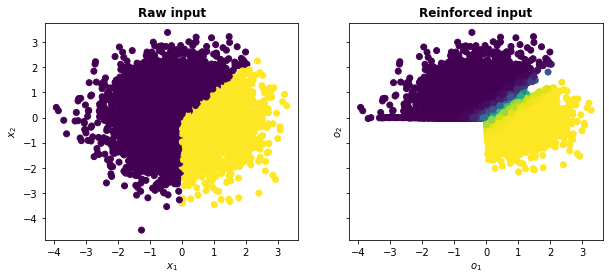

In [10]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='2DInteraction',seed =42)

## Noisy two moon example

In [11]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [12]:
X, y = make_moons(noise=0.05, random_state=0, n_samples=10000)
X_train_,X_test_,Y_train_,Y_test_ =  train_test_split(
        X, y, test_size=0.4, random_state=42
    )
n_features,n_classes,=2,2
len(Y_train_),len(Y_test_)

(6000, 4000)

In [13]:
## The hyperparameters 
config_opt = {'lr': 0.0074758577787202, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.000219536744026, 'batch_size': 256}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.9990132779875472 -- AUCPR perf = 0.9990036653666927


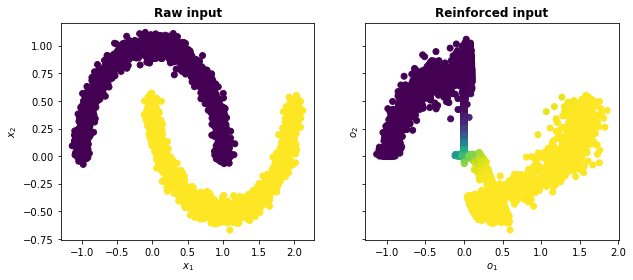

In [14]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='noisytwomoon',seed =42)

## Five sphere example

In [15]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'spherical_5_2.arff.txt')
data.head()

,x1,x2,y
0,11.11,10.14,1
1,8.68,9.76,1
2,10.04,10.63,1
3,8.79,10.13,1
4,10.53,8.95,1


In [16]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==1,1,0)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2

X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(250, 250)

In [17]:
## The hyperparameters 
config_opt = {'lr': 0.007, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.0002, 'batch_size': 50}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.9589000000000001 -- AUCPR perf = 0.8791197947798614


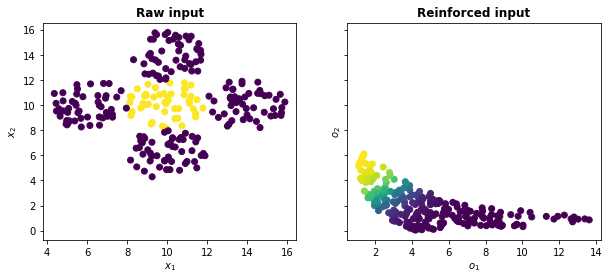

In [18]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='fivesphere',seed =45)

## Rings 

In [19]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'rings.arff.txt')
data.head()

,x1,x2,y
0,-0.127192,-0.194999,0
1,-10.070178,0.973600,2
2,1.909451,-4.072703,1
3,0.585665,9.816200,2
4,-5.459372,8.536418,2


In [20]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==2,0,1)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2
X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(1000, 1000)

In [21]:
## The hyperparameters 
config_opt = {'lr': 0.0074758577787202, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.00, 'batch_size': 25}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.9045449444506789 -- AUCPR perf = 0.9504293389238064


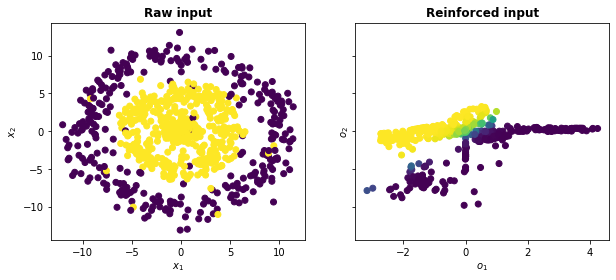

In [22]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='rings',seed =45)

## Two moon  example 

In [23]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'jain.arff.txt')
data.head()

,x1,x2,y
0,0.85,17.45,2
1,0.75,15.60,2
2,3.30,15.45,2
3,5.25,14.20,2
4,4.90,15.65,2


In [24]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==2,1,0)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2
X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(373, 373)

In [25]:
## The hyperparameters 
config_opt = {'lr': 0.007, 'dropout_rate': 0.0, 'dim_head': 4, 'epochs': 200, 'weight_decay': 0.0002, 'batch_size': 25}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 1.0 -- AUCPR perf = 0.9999999999999999


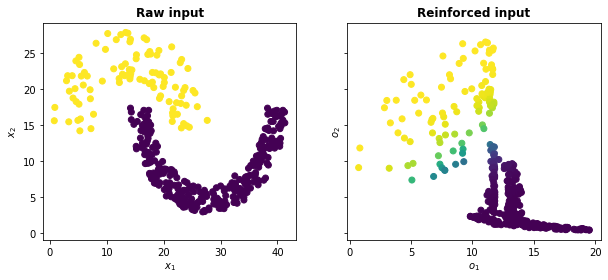

In [26]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='twomoon',seed =45)

## Dense disk 

In [27]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'dense-disk-3000.arff.txt')
data.head()

,x1,x2,y
0,7.588590,1.351370,0
1,-7.501600,0.536143,0
2,-9.051130,-2.403330,0
3,7.193110,-5.320450,0
4,-0.778891,9.183150,0


In [28]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==1,1,0)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2
X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(3000, 3000)

In [29]:
## The hyperparameters 
config_opt = {'lr': 0.0074758577787202, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.00, 'batch_size': 25}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.9379359641802701 -- AUCPR perf = 0.9742113954135484


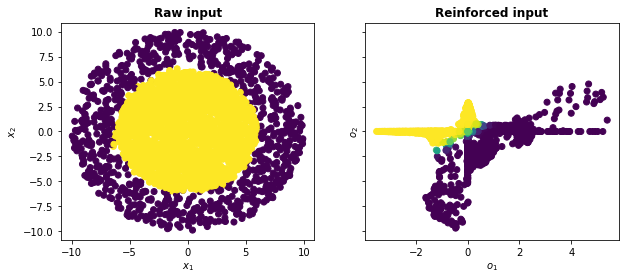

In [30]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='Densedisk',seed =45)

## Atom example

In [31]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'atom.arff.txt')
data.head()

,x1,x2,x3,y
0,-4.822490,-50.402170,4.020861,1
1,-44.460120,20.964670,-11.492060,1
2,50.001020,0.780748,9.134460,1
3,-41.699080,-22.310060,16.314120,1
4,4.425242,-4.666664,50.223740,1


In [32]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==1,0,1)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2

X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(800, 800)

In [33]:
## The hyperparameters 
config_opt = {'lr': 0.0074758577787202, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.000219536744026, 'batch_size': 50}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.98545625 -- AUCPR perf = 0.9862509984690843


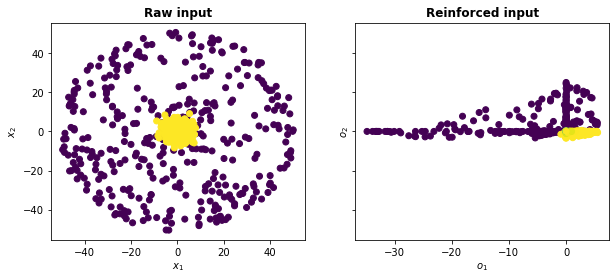

In [34]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='atom',seed =45)

### ChainLink example

In [35]:
data_path = '../Datasets/'
data = pd.read_csv(data_path+ 'chainlink.arff.txt')
data.head()

,x1,x2,x3,y
0,-0.452525,-0.890705,0.023005,1
1,0.652850,-0.845875,0.021084,1
2,0.397904,0.913450,-0.001391,1
3,0.095233,1.054986,0.006280,1
4,0.523990,-0.941104,0.037762,1


In [36]:
feature_names = list(data.columns)
feature_names.pop()
y = np.where(data['y']==1,0,1)
data = data[feature_names]
feature_names = list(data.columns)
X = data.values
n_features = p =  X.shape[1]
n_classes = 2

X_train_,X_test_,Y_train_,Y_test_ = X,X,y,y
len(Y_train_),len(Y_test_)

(1000, 1000)

In [37]:
## The hyperparameters 
config_opt = {'lr': 0.0074758577787202, 'dropout_rate': 0.0, 'dim_head': 8, 'epochs': 200, 'weight_decay': 0.000219536744026, 'batch_size': 50}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}

--AUCROC perf = 0.994976 -- AUCPR perf = 0.9958785370363581


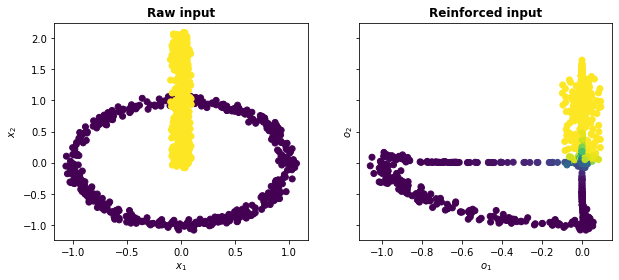

In [38]:
run_experiment(config_opt=config_opt,static_params=static_params,save_model_dir='chainlink',seed =45)